'''
24-05-27
label=1 vs label=0 일때 비교
'''

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 작업 디렉토리 설정
os.chdir('C:/Users/mose/agoda/data/') # os.chdir('C:/Users/UOS/Desktop/Agoda-Data/raw')

# 데이터 로드
eng = pd.read_csv("eng.csv", index_col=0)
eng = eng.reset_index(drop=True)

In [3]:
# 거리 행렬 로드
cnt_ham_dist = np.load('cnt_ham_distances.npy')
tf_l2_dist = np.load('tf_l2_distances.npy')

In [4]:
# 대각 원소를 모두 1로 설정
large_value = 1e6
np.fill_diagonal(cnt_ham_dist, large_value)
np.fill_diagonal(tf_l2_dist, large_value)

In [5]:
# 특정 텍스트의 유사한 텍스트 찾기
def find_neighbors(idx, dist_matrix, top_n=5):
    dist_row = dist_matrix[idx]
    neighbors = dist_row.argsort()[:top_n]
    return [(i, eng.loc[i]['difference']) for i in neighbors]

In [6]:
# 결과 출력 및 파일 저장
def save_to_file(filename, neighbors_dict, label):
    with open(filename, 'a') as f:
        f.write(f"Difference {label} neighbors' differences:\n")
        for i, neighbors in neighbors_dict.items():
            f.write(f"Review index {i}: Neighbors: {neighbors}\n")
        f.write("\n")

In [7]:
# difference가 1인 리뷰에 대한 이웃 찾기
diff_1_idx = eng[eng['difference'] == 1].index
diff_1_neighbors_cnt = {i: find_neighbors(i, cnt_ham_dist) for i in diff_1_idx}
diff_1_neighbors_tf = {i: find_neighbors(i, tf_l2_dist) for i in diff_1_idx}

In [8]:
# difference가 0인 리뷰에 대한 이웃 찾기
diff_0_idx = eng[eng['difference'] == 0].index
diff_0_neighbors_cnt = {i: find_neighbors(i, cnt_ham_dist) for i in diff_0_idx}
diff_0_neighbors_tf = {i: find_neighbors(i, tf_l2_dist) for i in diff_0_idx}

In [9]:
output_file = 'neighbors_output.txt'

In [10]:
# 파일 초기화
with open(output_file, 'w') as f:
    f.write("Neighbors analysis results\n\n")

In [11]:
# 결과 저장
save_to_file(output_file, diff_1_neighbors_cnt, 1)
save_to_file(output_file, diff_0_neighbors_cnt, 0)
save_to_file(output_file, diff_1_neighbors_tf, 1)
save_to_file(output_file, diff_0_neighbors_tf, 0)

In [12]:
print(f"Results saved to {output_file}")

Results saved to neighbors_output.txt


'''
시각화
'''

In [13]:
# 각 리뷰의 이웃들과의 거리 값을 수집하는 함수
def gather_neighbor_distances(neighbors_dict, dist_matrix):
    neighbor_distances = []
    for idx, neighbors in neighbors_dict.items():
        for neighbor_idx, _ in neighbors:
            neighbor_distances.append(dist_matrix[idx, neighbor_idx])
    return neighbor_distances

In [14]:
# boxplot 생성
def create_boxplot(data, labels, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

In [15]:
# difference가 1인 리뷰들의 이웃 거리 값 모으기
diff_1_neighbors_cnt_distances = gather_neighbor_distances(diff_1_neighbors_cnt, cnt_ham_dist)
diff_1_neighbors_tf_distances = gather_neighbor_distances(diff_1_neighbors_tf, tf_l2_dist)

In [16]:
# difference가 0인 리뷰들의 이웃 거리 값 모으기
diff_0_neighbors_cnt_distances = gather_neighbor_distances(diff_0_neighbors_cnt, cnt_ham_dist)
diff_0_neighbors_tf_distances = gather_neighbor_distances(diff_0_neighbors_tf, tf_l2_dist)

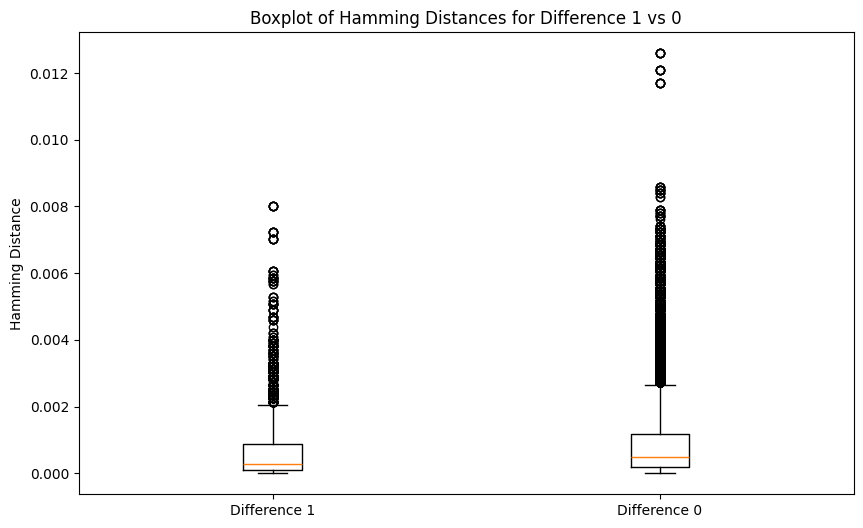

In [17]:
# Hamming distances boxplot
create_boxplot([diff_1_neighbors_cnt_distances, diff_0_neighbors_cnt_distances],
               ['Difference 1', 'Difference 0'],
               'Boxplot of Hamming Distances for Difference 1 vs 0',
               'Hamming Distance')

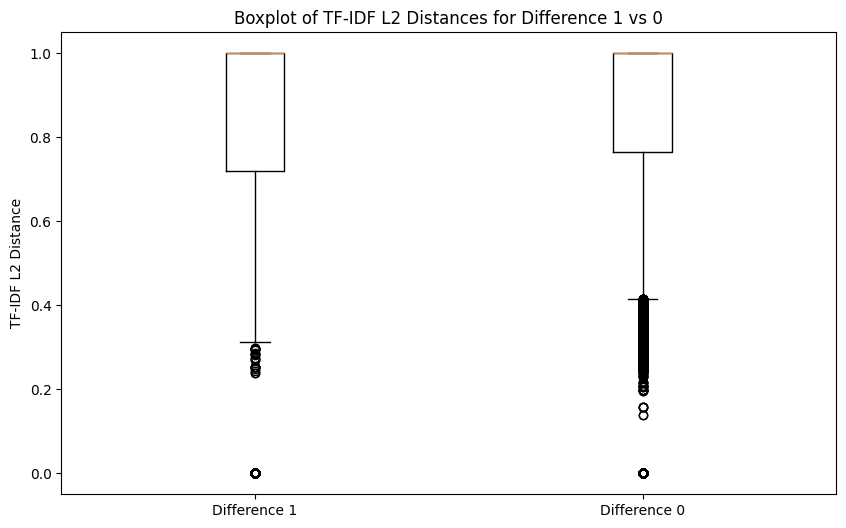

In [18]:
# TF-IDF L2 distances boxplot
create_boxplot([diff_1_neighbors_tf_distances, diff_0_neighbors_tf_distances],
               ['Difference 1', 'Difference 0'],
               'Boxplot of TF-IDF L2 Distances for Difference 1 vs 0',
               'TF-IDF L2 Distance')

In [19]:
from scipy.stats import ttest_ind

# Hamming distance에 대한 t-test
ttest_hamming = ttest_ind(diff_1_neighbors_cnt_distances, diff_0_neighbors_cnt_distances)
print(f"Hamming Distance t-test: statistic={ttest_hamming.statistic}, pvalue={ttest_hamming.pvalue}")

# TF-IDF L2 distance에 대한 t-test
ttest_tfidf = ttest_ind(diff_1_neighbors_tf_distances, diff_0_neighbors_tf_distances)
print(f"TF-IDF L2 Distance t-test: statistic={ttest_tfidf.statistic}, pvalue={ttest_tfidf.pvalue}")

Hamming Distance t-test: statistic=-10.99711836296364, pvalue=4.126703064986363e-28
TF-IDF L2 Distance t-test: statistic=-8.424617898533665, pvalue=3.676407154537204e-17


C:\Users\mose\AppData\Local\Temp\ipykernel_8340\4163720385.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_1_neighbors_cnt_distances, label='Difference 1', shade=True)
C:\Users\mose\AppData\Local\Temp\ipykernel_8340\4163720385.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_0_neighbors_cnt_distances, label='Difference 0', shade=True)


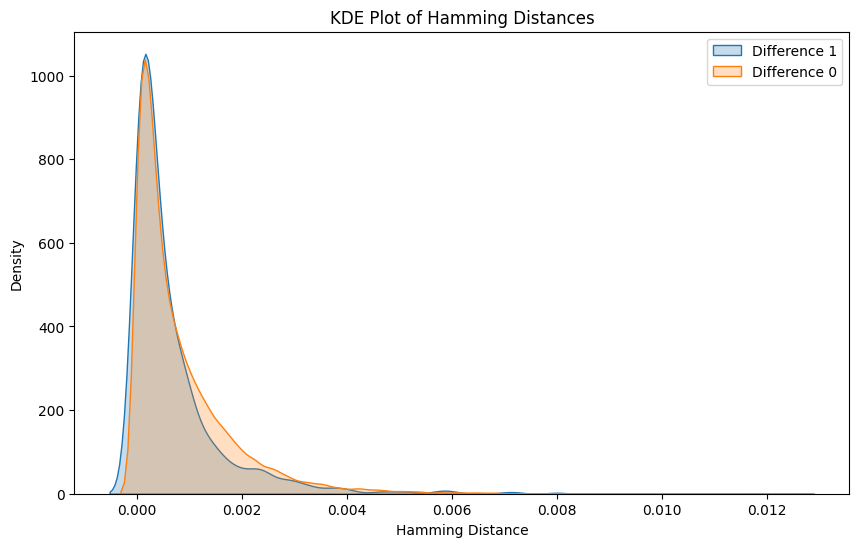

C:\Users\mose\AppData\Local\Temp\ipykernel_8340\4163720385.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_1_neighbors_tf_distances, label='Difference 1', shade=True)
C:\Users\mose\AppData\Local\Temp\ipykernel_8340\4163720385.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_0_neighbors_tf_distances, label='Difference 0', shade=True)


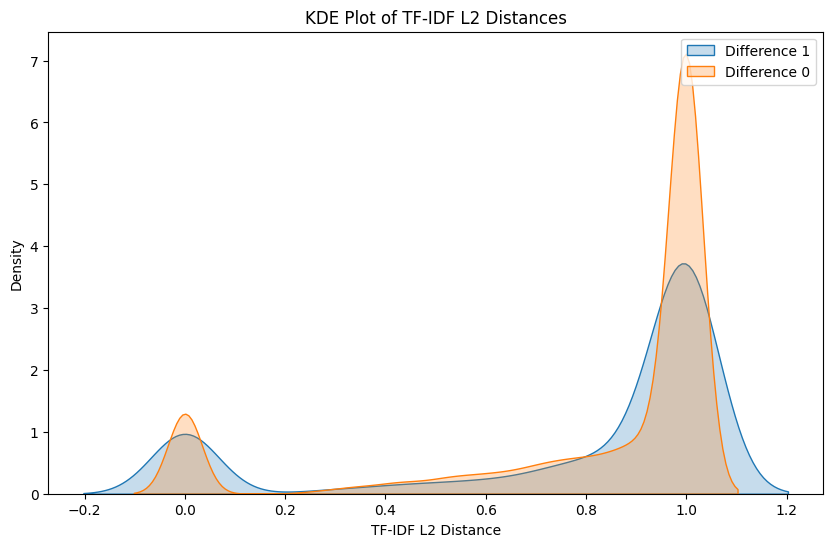

In [20]:
import seaborn as sns

# KDE plot for Hamming distances
plt.figure(figsize=(10, 6))
sns.kdeplot(diff_1_neighbors_cnt_distances, label='Difference 1', shade=True)
sns.kdeplot(diff_0_neighbors_cnt_distances, label='Difference 0', shade=True)
plt.title('KDE Plot of Hamming Distances')
plt.xlabel('Hamming Distance')
plt.legend()
plt.show()

# KDE plot for TF-IDF L2 distances
plt.figure(figsize=(10, 6))
sns.kdeplot(diff_1_neighbors_tf_distances, label='Difference 1', shade=True)
sns.kdeplot(diff_0_neighbors_tf_distances, label='Difference 0', shade=True)
plt.title('KDE Plot of TF-IDF L2 Distances')
plt.xlabel('TF-IDF L2 Distance')
plt.legend()
plt.show()

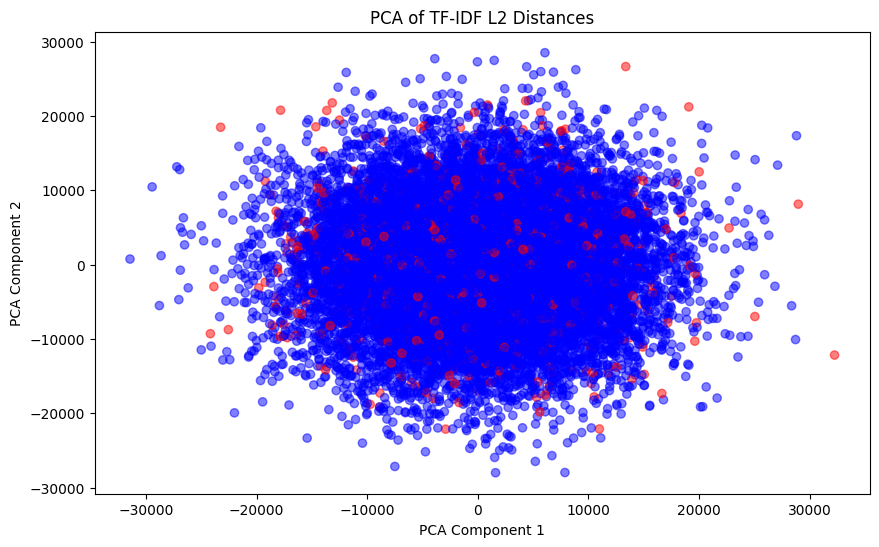

In [21]:
from sklearn.decomposition import PCA

# 차원 축소 (오류 : ValueError: Input X contains infinity or a value too large for dtype('float64').)
pca = PCA(n_components=2)
distances_pca = pca.fit_transform(tf_l2_dist)

# difference에 따라 색상 구분
colors = ['red' if diff == 1 else 'blue' for diff in eng['difference']]

# 산점도
plt.figure(figsize=(10, 6))
plt.scatter(distances_pca[:, 0], distances_pca[:, 1], c=colors, alpha=0.5)
plt.title('PCA of TF-IDF L2 Distances')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [22]:
from sklearn.cluster import KMeans

# KMeans 클러스터링 (오류)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(tf_l2_dist)

# 클러스터별 difference 비율
cluster_0_diff = eng.loc[clusters == 0, 'difference'].value_counts(normalize=True)
cluster_1_diff = eng.loc[clusters == 1, 'difference'].value_counts(normalize=True)

print(f"Cluster 0 difference distribution:\n{cluster_0_diff}")
print(f"Cluster 1 difference distribution:\n{cluster_1_diff}")

Cluster 0 difference distribution:
difference
0    0.94849
1    0.05151
Name: proportion, dtype: float64
Cluster 1 difference distribution:
difference
0    0.940138
1    0.059862
Name: proportion, dtype: float64


In [23]:
from scipy.stats import ks_2samp

# KS 검정 수행
ks_statistic_hamming, ks_pvalue_hamming = ks_2samp(diff_1_neighbors_cnt_distances, diff_0_neighbors_cnt_distances)
ks_statistic_tfidf, ks_pvalue_tfidf = ks_2samp(diff_1_neighbors_tf_distances, diff_0_neighbors_tf_distances)

# 결과 출력
print(f"Hamming Distance KS test: statistic={ks_statistic_hamming}, pvalue={ks_pvalue_hamming}")
print(f"TF-IDF L2 Distance KS test: statistic={ks_statistic_tfidf}, pvalue={ks_pvalue_tfidf}")

Hamming Distance KS test: statistic=0.10072276505147987, pvalue=3.6951543337928384e-41
TF-IDF L2 Distance KS test: statistic=0.05512398733612303, pvalue=1.296255468780768e-12
